In [0]:
import numpy as np

%tensorflow_version 1.x
from keras import applications
from keras.layers import Dense, Dropout, MaxPool2D, GlobalAveragePooling2D, Flatten
from keras.models import Model
from keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix, roc_curve

import seaborn

from matplotlib import pyplot as plt

import random
from random import shuffle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
HEADER = 'drive/My Drive/Colab Notebooks/BDRAD/mini-cv/processed/'

TRAIN_EXAMPLES_PATH = HEADER + 'Mass-Training-Examples.npz'
TRAIN_LABELS_PATH = HEADER + 'Mass-Training-Labels.npz'

TEST_EXAMPLES_PATH = HEADER + 'Mass-Test-Examples.npz'
TEST_LABELS_PATH = HEADER + 'Mass-Test-Labels.npz'

In [0]:
def load(examples_path, labels_path):
    examples, labels = np.load(examples_path), np.load(labels_path)
    examples, labels = examples.f.arr_0, labels.f.arr_0
    examples = np.repeat(examples[..., np.newaxis], 3, -1)*65535
    #examples = np.expand_dims(examples, axis=3) 
    num_labels = labels.shape[0]
    one_hot = np.zeros([num_labels, 2])
    for i in range(num_labels):
        label = 0 if int(labels[i]) <= 2 else 1
        one_hot[i][label] = 1
    return examples, one_hot
    

In [8]:
train_examples, train_labels = load(TRAIN_EXAMPLES_PATH, TRAIN_LABELS_PATH)
test_examples, test_labels = load(TEST_EXAMPLES_PATH, TEST_LABELS_PATH)

# from matplotlib import pyplot as plt
# plt.imshow(train_examples[2])
#print(np.max(test_examples[2]))

# plt.imshow(65535 * np.repeat(test_examples[..., np.newaxis], 3, -1)[2])

def show(number, train=True):
  if train:
    dataset, labels = train_examples, train_labels
  else:
    dataset, labels = test_examples, test_labels
  plt.figure()
  print('train' if train else 'test')
  print('dense' if labels[number][0] else 'not dense')
  plt.imshow(dataset[number])

def get_perc(train=True):
  if train:
    dataset, name = train_labels, 'train'
  else:
    dataset, name = test_labels, 'test'


  num_dense = len([label for label in dataset if label[0]])
  print('Percent dense {0}: {1}'.format(name, num_dense / len(train_labels) * 100))

get_perc(True)
get_perc(False)

Percent dense train: 62.71186440677966
Percent dense test: 26.27118644067797


In [0]:
#normalize data to get equal numbers dense and not dense to avoid skewing model
examples = np.concatenate([train_examples, test_examples], axis=0)
labels = np.concatenate([train_labels, test_labels], axis=0)

dense, not_dense = [], []
for i in range(len(labels)):
  if labels[i][0]:
    #dense example
    dense.append((examples[i], labels[i]))
  else:
    #not dense example
    not_dense.append((examples[i], labels[i]))
  
if len(dense) > len(not_dense):
  dense = dense[:len(not_dense)]
else:
  not_dense = not_dense[:len(dense)]

cutoff = int(len(dense) * 0.9)

train = dense[:cutoff] + not_dense[:cutoff]
test = dense[cutoff:] + not_dense[cutoff:]

shuffle(train)
shuffle(test)

train_examples, train_labels = zip(*train)
test_examples, test_labels = zip(*test)

train_examples = np.array(train_examples)
train_labels = np.array(train_labels)
test_examples = np.array(test_examples)
test_labels = np.array(test_labels) 

In [41]:
"""
Modified from https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Network_Keras.ipynb
"""

NUM_CLASSES = 2

"""Tried varying levels of dropout ranging from 0.1-0.7, got best results with 0.25"""
dropout = 0.25

INPUT_SHAPE = (224, 224, 3)

base_model = applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

"""Tried only training last layers, but achieved significantly worse performance"""
# for layer in base_model.layers:
#   layer.trainable = False

x = base_model.output
#x = Flatten()(x)

"""Prepare model for final classification"""
x = GlobalAveragePooling2D()(x)

"""Dropout layer to prevent overfitting"""
x = Dropout(dropout)(x)

"""Final dense layer for classification"""
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs = base_model.input, outputs = predictions)

"""Adam performed better than SGD"""
adam = Adam(lr=0.0001)
#sgd = SGD(lr=0.0001, momentum=0.9, decay=1e-6, nesterov=True)

"""Tried binary_crossentropy vs categorical_crossentropy"""
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [42]:
"""Tried 5, 7, 10 epochs"""
epochs = 7

"""Tried batch sizes of 8, 16, 32"""
batch_size = 32

model.fit(train_examples, train_labels, epochs=epochs, batch_size=batch_size,
         validation_data=(test_examples, test_labels))

"""
Summary:
I tuned a lot of parameters in an attempt to prevent overfitting as much as possible,
but this was about the best I could get by changing the dropout, learning rate, optimizer, activation function, batch size, etc.
I'd guess that the problems might be (1) a small dataset and (2) too big of a model, since these tend to be causes
of overfitting. For the model, it's possible that a smaller ResNET architecture like ResNet-16 would have worked better,
but I couldn't find an easy way to implement it in keras so I didn't think it would have been a good use of time for this
particular mini-project.
"""

Train on 350 samples, validate on 40 samples
Epoch 1/7
350/350 [==============================] - 41s 117ms/step - loss: 0.5970 - acc: 0.7257 - val_loss: 0.7029 - val_acc: 0.6500
Epoch 2/7
350/350 [==============================] - 5s 14ms/step - loss: 0.1179 - acc: 0.9600 - val_loss: 0.6446 - val_acc: 0.6750
Epoch 3/7
350/350 [==============================] - 5s 14ms/step - loss: 0.0315 - acc: 0.9943 - val_loss: 0.6824 - val_acc: 0.7750
Epoch 4/7
350/350 [==============================] - 5s 14ms/step - loss: 0.0103 - acc: 1.0000 - val_loss: 0.4623 - val_acc: 0.8750
Epoch 5/7
350/350 [==============================] - 5s 14ms/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.3196 - val_acc: 0.9250
Epoch 6/7
350/350 [==============================] - 5s 15ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.2859 - val_acc: 0.9500
Epoch 7/7
350/350 [==============================] - 5s 14ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.2541 - val_acc: 0.9500


"\nSummary:\nI tuned a lot of parameters in an attempt to prevent overfitting as much as possible,\nbut this was about the best I could get by changing the dropout, learning rate, optimizer, activation function, batch size, etc.\nI'd guess that the problems might be (1) a small dataset and (2) too big of a model, since these tend to be causes\nof overfitting. For the model, it's possible that a smaller ResNET architecture like ResNet-16 would have worked better,\nbut I couldn't find an easy way to implement it in keras so I didn't think it would have been a good use of time for this\nparticular mini-project.\n"

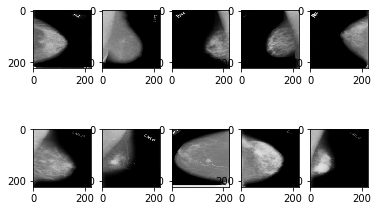

In [43]:
F"""
Adapted from https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly/46616645
"""

fig=plt.figure()
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    img = examples[int(random.random() * len(examples))]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

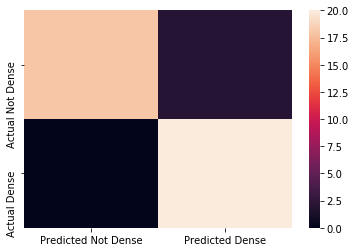

In [44]:
predictions = model.predict(test_examples)
seaborn.heatmap(confusion_matrix(test_labels.argmax(axis=1), predictions.argmax(axis=1)),
                yticklabels=['Actual Not Dense', 'Actual Dense'], xticklabels=['Predicted Not Dense', 'Predicted Dense'])

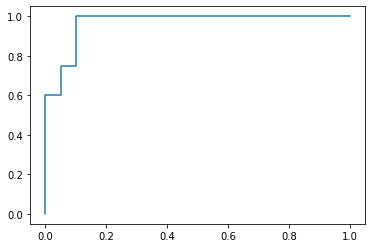

In [45]:
fpr, tpr, _ = roc_curve(test_labels[:,1],predictions[:,1])
plt.plot(fpr,tpr)